In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def generate_spiral_dataset(N, K):
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # rayon
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

In [3]:
N = 100 # nombre de points par classe
K = 3 # nombre de classes
X, Y = generate_spiral_dataset(N, K)

X = X
Y_classes = Y

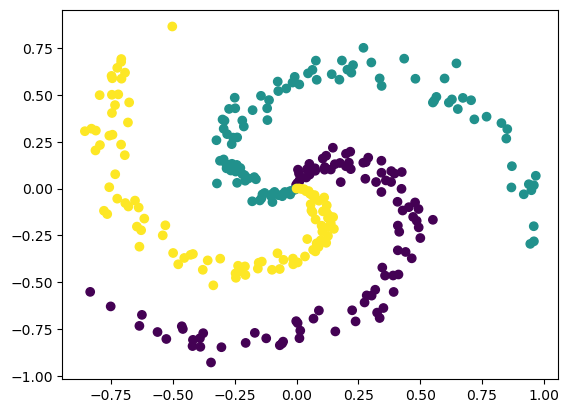

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [5]:
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y)

In [6]:
device = 'cpu' #torch.device("cuda")

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, axis=1)
    
    def get_flatten_params(self):
        flatten_params = torch.tensor([], device=device)

        for p in model.parameters():
            flatten_params = torch.cat((flatten_params, torch.flatten(p)))

        return flatten_params
    
    def _get_param_shapes(self):
        param_shapes = []
        for p in self.parameters():
            param_shapes.append(p.size())
        return param_shapes
    
    def init_from_flatten_params(self, flatten_params):
        param_shapes = self._get_param_shapes()
        param_sizes = [torch.prod(torch.tensor(shape)).item() for shape in param_shapes]
        split_params = torch.split(flatten_params, param_sizes)

        for p, split_param in zip(model.parameters(), split_params):
            p.data.copy_(split_param.view(p.size()))

model = MLP()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [25]:
for epoch in range(1000):
    output = model(X)

    optimizer.zero_grad()
    loss = F.nll_loss(output, Y)
    loss.backward()
    optimizer.step()
print(loss.item())

0.029728339985013008


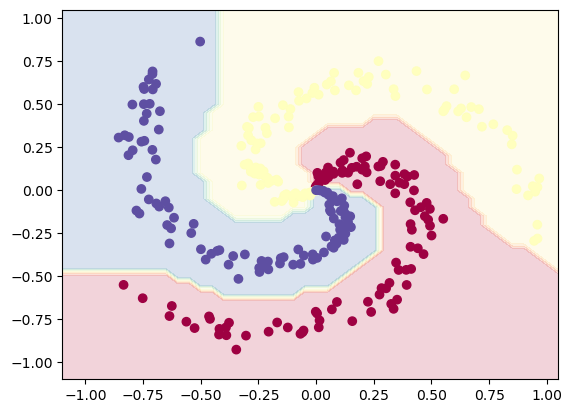

In [26]:
xx, yy = np.meshgrid(np.arange(-1.1, 1.1, 0.05), np.arange(-1.1, 1.1, 0.05))
X_disp = np.c_[xx.ravel(), yy.ravel()].T

h = model.predict(torch.from_numpy(X_disp.T.astype(np.float32)))
h = h.reshape(xx.shape)

plt.contourf(xx, yy, h, cmap=plt.cm.Spectral, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=Y_classes, cmap=plt.cm.Spectral)

In [73]:
flat_params_adam = model.get_flatten_params()

In [94]:
flat_params_sgd = model.get_flatten_params()

In [117]:
alphas = torch.linspace(start=-0.4, end=1.5, steps=100)
losses = []

model = MLP()
model.to(device)

for alpha in alphas:
    #print("alpha = {}".format(alpha))
    #calculer le cout pour alpha * theta_0 + (1-alpha) * theta_1

    model.init_from_flatten_params(alpha * flat_params_sgd + (1 - alpha) * flat_params_adam)
    loss = 0

    with torch.no_grad():
        output = model(X)
        loss = F.nll_loss(output, Y).item()

    losses.append(loss)

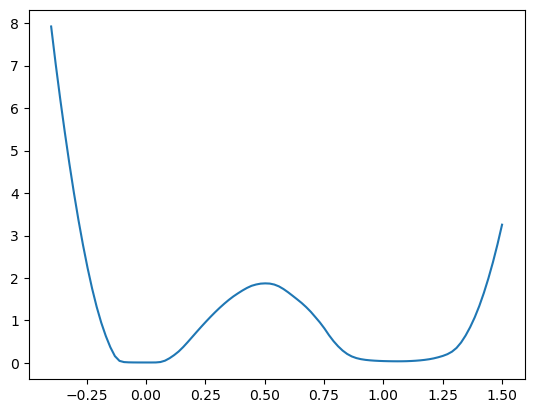

In [118]:
plt.plot(alphas, losses)